# PLUTO Data Scrape

In this section, we will retrieve and query the Primary Land Use Tax Lot Output (PLUTO) from the NYC Open Data Resources which provides extensive land use and geographic data at the tax lot level in NYC. We are primarily interested in the building and landuse categories in NYC which will be useful in our analysis later on.

### Aim: 
- Count and categorise available buildings based on the Zones provided from TLC dataset.

### Data dictionary:
- Can be retrieved from this link: [PLUTO Data Dictionary](https://data.cityofnewyork.us/api/views/64uk-42ks/files/4236b586-c55e-4358-a21a-3647735dd58b?download=true&filename=pluto_datadictionary.pdf) 

In [1]:
# Secret key: 1ivd0fqtp4xbx0pqhsv0183ibshswr50pypynvsow5sk2h6yaw
# API key: 353e1ik63ytdkgwm4bfni5vtd
# App token: UMXzWyQUIWIjSyhP5AKzUew4x

from sodapy import Socrata
import pandas as pd
import requests
import json
import geopandas as gpd
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Access NYC Open Data Api
app_token = 'UMXzWyQUIWIjSyhP5AKzUew4x'

client = Socrata("data.cityofnewyork.us", app_token)

In [3]:
# Retrieve the latest PLUTO data 
query = """
SELECT
    borough, 
    landuse, 
    BldgClass,
    latitude, 
    longitude,
    zipcode,
    version,
    UnitsTotal,
    UnitsRes
WHERE landuse IS NOT NULL AND version = '22v1'
LIMIT 1000000
"""

results = client.get("64uk-42ks", query=query)


In [4]:
# Read result and convert to geopandas dataframe format
results_df = pd.DataFrame.from_records(results)

results_gdf = gpd.GeoDataFrame(
    results_df,
    geometry=gpd.points_from_xy(results_df.longitude, results_df.latitude)
)

results_gdf.crs = 'epsg:4326'

## Building Classes

Based on the data dictionary, the pluto dataset offers high granularity data for this column. For instance, under the category H. Hotels, we have H1. Luxury Type, H2. Full Service Hotel, and so on. 

For our research purpose, we are only interested in the general purpose of the lot (Eg. 'Residential' instead of 'One-bedroom apartment') so we will only be extracting the general category of the lot.

In [5]:
# Extract only the general use of the lot 
results_gdf['BldgClass'] = results_gdf['BldgClass'].apply(lambda x: x[0])

results_gdf['BldgClass'].unique()

array(['A', 'B', 'V', 'C', 'K', 'G', 'S', 'M', 'D', 'E', 'R', 'Q', 'I',
       'W', 'O', 'P', 'F', 'Z', 'H', 'N', 'U', 'Y', 'T', 'J'],
      dtype=object)

## Feature Engineering on PLUTO dataset

In [26]:
# Convert the UnitsTotal and UnitsRes to numeric
results_gdf[['UnitsTotal', 'UnitsRes']] = results_gdf[['UnitsTotal', 'UnitsRes']].apply(pd.to_numeric)

# Check if there is any anomalies in the data 
len(results_gdf[results_gdf['UnitsTotal'] < results_gdf['UnitsRes']])

0

Based on the data dictionary, `UnitsTotal` = `UnitsRes` + number of non-residential units, which is verified above since there is no data with total units less than residential units.

In [32]:
# Rename columns for consistency
results_gdf.rename({'UnitsRes':'residential_units',
                    'BldgClass':'building_class',
                    'UnitsTotal':'total_units'},
                   axis = 1,
                   inplace = True)

# Reorder columns and drop irrelevant columns
results_gdf = results_gdf[['borough',
                           'landuse',
                           'building_class',
                           'residential_units',
                           'non_residential_units',
                           'total_units',
                           'zipcode',
                           'geometry']]

In [33]:
results_gdf

,borough,landuse,building_class,residential_units,non_residential_units,total_units,zipcode,geometry
0,QN,1,A,1.0,0.0,1.0,11420,POINT (-73.81281 40.67806)
1,QN,1,A,1.0,0.0,1.0,11420,POINT (-73.81172 40.67582)
2,QN,1,A,1.0,0.0,1.0,11420,POINT (-73.80642 40.67759)
3,QN,1,B,2.0,0.0,2.0,11420,POINT (-73.81379 40.67597)
4,QN,1,B,2.0,0.0,2.0,11420,POINT (-73.80652 40.67779)
...,...,...,...,...,...,...,...,...
856972,QN,1,B,2.0,0.0,2.0,11420,POINT (-73.81236 40.67793)
856973,QN,1,A,1.0,0.0,1.0,11420,POINT (-73.80611 40.67774)
856974,QN,1,A,1.0,0.0,1.0,11420,POINT (-73.81270 40.67784)
856975,QN,1,A,1.0,0.0,1.0,11420,POINT (-73.81277 40.67798)


In [7]:
landuse_dict = {1: 'residential_building',
                2: 'residential_building',
                3: 'residential_building',
                4: 'residential_building',
                5: 'commercial_and_office_building',
                6: 'industrial_and_manufacturing',
                7: 'transport_and_utility',
                8: 'public_facilities_and_institutions',
                9: 'open_space_outdoor_recreation',
                10: 'parking_facilities',
                11: 'vacant_land'}

## TLC Zone Dataset

Since the TLC Zone dataset is less granular, we can use spatial join on the pluto and the TLC Zone data to group buildings within their respective Zones specified by the `LocationID` in TLC Zone dataset.

In [41]:
# Read the shapefile of the tlc zone dataset
sf = gpd.read_file("/Users/oliver/Downloads/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("/Users/oliver/Downloads/taxi_zones/taxi+_zone_lookup.csv")


In [42]:
# Convert the geometry shape to longitude and latitude
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [43]:
# Merge the zone lookup csv and the shapefile
tlc_gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
).drop(['Zone','Borough'], axis=1)

tlc_gdf.head()

,LocationID,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."


In [46]:
# Spatial join on the pluto and tlc zone data using the 'within' operator
sjoined_df = gpd.sjoin(
    results_gdf, tlc_gdf, op='within'
).drop(['index_right','borough_left'], axis=1)

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: +proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs + ...

  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
# Rename columns for consistency
sjoined_df = sjoined_df.rename({'OBJECTID':'object_id',
                                'LocationID':'location_id',
                                'borough_right':'borough'}, 
                                axis=1)

In [67]:
sjoined_df.columns

Index(['landuse', 'building_class', 'residential_units',
       'non_residential_units', 'total_units', 'zipcode', 'geometry',
       'location_id', 'service_zone', 'object_id', 'Shape_Leng', 'Shape_Area',
       'zone', 'borough'],
      dtype='object')

## Count buildings in each LocationID based on their building categories

Here we will create a new TLC_zone data by generating column for each `BldgClass` and count the buildings in each `LocationID` based on their `BldgClass`.

In [71]:
# Extract all available building classes
building_class_col = sjoined_df['building_class'].unique()

In [73]:
def sort_category_based_zone(groupby, op_column, operation):
    """
    Group and count the number of instances in the joined dataframe based on the category
    given in each location id.
    
    Param:
        groupby: column name in the PLUTO dataset to groupby
        op_column: column in PLUTO dataset to apply operation
        operation: aggregate operations such as 'sum', 'mean', 'count'...
        
    Output:
        dataframe: dataframe of operation applied on instances grouped by the category in each location id
    
    """
    
    # Groupby given column name and apply operation on the column specified
    count_category = sjoined_df.groupby(['location_id', groupby]).agg({op_column: operation})
    
    # Get all unique elements in the category
    category = sjoined_df[groupby].unique()
    
    tlc_gdf_v2 = tlc_gdf.copy()
    
    # Add columns for each given value in the category
    tlc_gdf_v2 = tlc_gdf_v2.reindex(columns = tlc_gdf.columns.tolist() + list(category))
    
    # 
    for idx, row in count_category.reset_index().iterrows():
        loc_id = row['location_id']
        cat = row[groupby]
        count = row[op_column]
        tlc_gdf_v2.loc[(tlc_gdf_v2['LocationID'] == loc_id), cat] = count 
    
    
    return tlc_gdf_v2

In [77]:
total_unit_df = sort_category_based_zone('building_class', 'total_units', 'sum')
total_res_unit_df = sort_category_based_zone('building_class', 'residential_units', 'sum')
total_nonres_unit_df = sort_category_based_zone('building_class', 'non_residential_units', 'sum')

In [78]:
total_unit_df.columns

Index(['LocationID', 'service_zone', 'OBJECTID', 'Shape_Leng', 'Shape_Area',
       'zone', 'borough', 'geometry', 'A', 'B', 'C', 'V', 'S', 'D', 'K', 'O',
       'M', 'G', 'W', 'E', 'N', 'P', 'F', 'Z', 'U', 'Q', 'H', 'Y', 'I', 'R',
       'J', 'T'],
      dtype='object')

In [79]:
# Gather total lots in each location ID
building_classes = sjoined_df['building_class'].unique()
total_res_unit_df['total_residential_per_location'] = total_res_unit_df[building_classes].sum(axis=1)
total_unit_df['total_unit_per_location'] = total_unit_df[building_classes].sum(axis=1)
total_nonres_unit_df['total_nonres_per_location'] = total_nonres_unit_df[building_classes].sum(axis=1)

In [176]:
# Gather total residential lots in each location ID
total_res_unit_df['total_residential'] = total_res_unit_df[sjoined_df['BldgClass'].unique()].sum(axis=1)
total_unit_df['total_unit'] = total_unit_df[sjoined_df['BldgClass'].unique()].sum(axis=1)

In [81]:
total_res_unit_df.head()

,LocationID,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,A,B,...,Z,U,Q,H,Y,I,R,J,T,total_residential_per_location
0,1,EWR,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,2,Boro Zone,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...",NaN,NaN,...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,3,Boro Zone,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",2392.0,4588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,NaN,NaN,9568.0
3,4,Yellow Zone,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725...",4.0,14.0,...,0.0,0.0,0.0,NaN,0.0,1.0,935.0,NaN,0.0,13583.0
4,5,Boro Zone,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562...",5737.0,3176.0,...,0.0,NaN,0.0,NaN,0.0,NaN,395.0,NaN,NaN,9336.0


## Quick visualization for inspection

Text(0.5, 1.0, 'Borough in NYC')

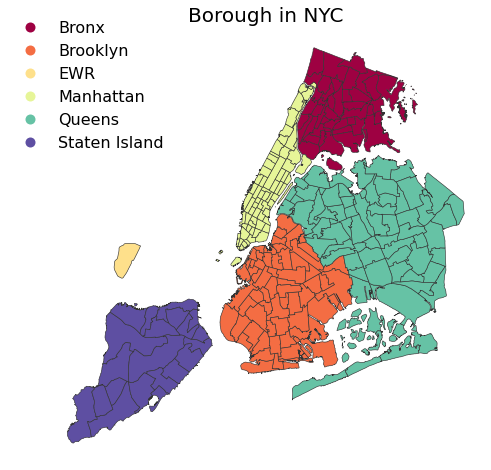

In [170]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_res_unit_df.plot(column='Borough', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Borough in NYC',fontsize=20)


Text(0.5, 1.0, 'Service Zone in NYC')

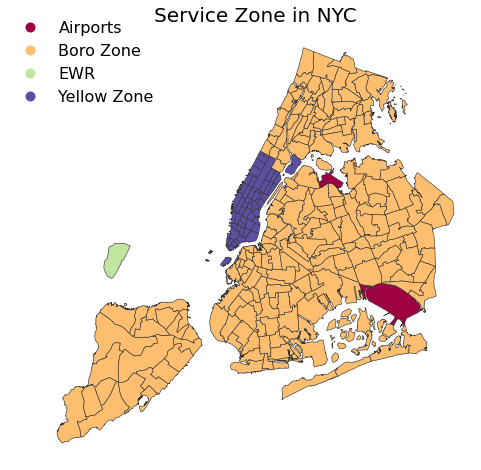

In [171]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_res_unit_df.plot(column='service_zone', categorical=True, cmap='Spectral', linewidth=.6, edgecolor='0.2',
         legend=True, legend_kwds={'bbox_to_anchor':(.3, 1.05),'fontsize':16,'frameon':False}, ax=ax)
ax.axis('off')
ax.set_title('Service Zone in NYC',fontsize=20)



Text(0.5, 1.0, 'Number of Residential Units in NYC')

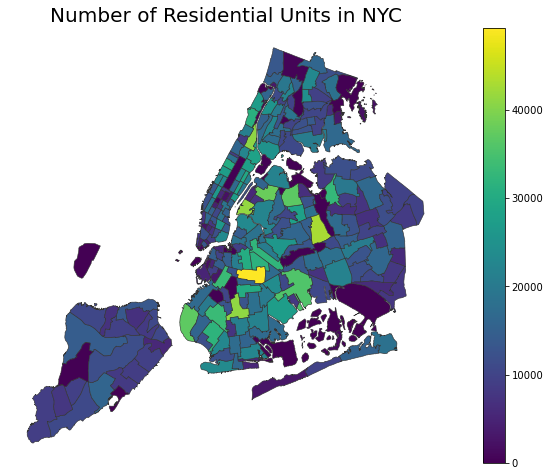

In [82]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_res_unit_df.plot(column='total_residential_per_location', categorical=False, linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax)
ax.axis('off')
ax.set_title('Number of Residential Units in NYC',fontsize=20)



Text(0.5, 1.0, 'Number of Non-Residential Units in NYC')

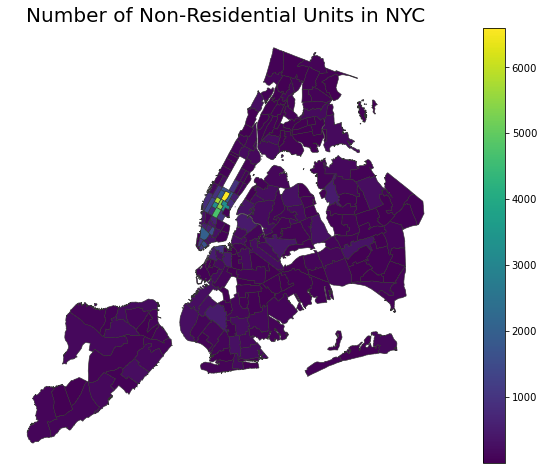

In [90]:
fig, ax = plt.subplots(1, figsize=(14,8))
total_unit_df.plot(column='O', categorical=False, linewidth=.6, edgecolor='0.2',
         legend=True, ax=ax)
ax.axis('off')
ax.set_title('Number of Non-Residential Units in NYC',fontsize=20)




In [205]:
total_unit_df[total_unit_df['Borough'] == 'Manhattan']['zone'].unique()

array(['Alphabet City', 'Battery Park', 'Battery Park City',
       'Bloomingdale', 'Central Harlem', 'Central Harlem North',
       'Central Park', 'Chinatown', 'Clinton East', 'Clinton West',
       'East Chelsea', 'East Harlem North', 'East Harlem South',
       'East Village', 'Financial District North',
       'Financial District South', 'Flatiron', 'Garment District',
       "Governor's Island/Ellis Island/Liberty Island", 'Gramercy',
       'Greenwich Village North', 'Greenwich Village South',
       'Hamilton Heights', 'Highbridge Park', 'Hudson Sq', 'Inwood',
       'Inwood Hill Park', 'Kips Bay', 'Lenox Hill East',
       'Lenox Hill West', 'Lincoln Square East', 'Lincoln Square West',
       'Little Italy/NoLiTa', 'Lower East Side', 'Manhattan Valley',
       'Manhattanville', 'Marble Hill', 'Meatpacking/West Village West',
       'Midtown Center', 'Midtown East', 'Midtown North', 'Midtown South',
       'Morningside Heights', 'Murray Hill',
       'Penn Station/Madison Sq W

In [228]:
total_res_unit_df[(total_res_unit_df['LocationID'] == 79)]

,LocationID,Borough,Zone,service_zone,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry,...,Z,U,Q,H,Y,I,R,J,T,total_residential
78,79,Manhattan,East Village,Yellow Zone,79,0.042625,0.000108,East Village,Manhattan,"POLYGON ((-73.98378 40.72154, -73.98382 40.721...",...,0.0,0.0,0.0,379.0,0.0,1.0,2546.0,5.0,NaN,26329.0


In [210]:
total_unit_df[(total_unit_df['Borough'] == 'Manhattan')]['LocationID'].unique()

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 103, 107, 113, 114, 116, 120, 125, 127,
       128, 137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161,
       162, 163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230,
       231, 232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261,
       262, 263])